# Forecast transit time

This is a regression task, so each CME event is associated with the value of the transit time from the Sun to Earth, calculated as the difference between the take-off time and the arrival time. This information is already contained in the source lists mentioned above.

We will use a dataset already prepared by [Alobaid et al. 2022](https://www.frontiersin.org/articles/10.3389/fspas.2022.1013345/full) and available at the following [link](https://github.com/deepsuncode/CMETNet/blob/main/CMETNet_Package/data/ICME_list.csv).


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [2]:
# Download the dataset:
link = 'https://raw.githubusercontent.com/deepsuncode/CMETNet/main/CMETNet_Package/data/ICME_list.csv'

download = False
if download:
    import urllib.request
    import os
    os.makedirs('transitTime', exist_ok=True)
    urllib.request.urlretrieve(link, 'transitTime/ICME_list.csv')

('transitTime/ICME_list.csv', <http.client.HTTPMessage at 0x168be6080>)

In [3]:
# Read the dataset with pandas:
df = pd.read_csv('transitTime/ICME_list.csv')

In [4]:
df

,disturbance,transit_time,angular_width,MPA,avg_speed,final_speed,mass,BX,BZ_GSE,Plasma_Temp,Plasma_Speed,Plasma_flow_long,Alpha_Prot_ratio,flow_pressure
0,1996-08-14 19:30:00,36.0,235.0,237.0,691.0,394.0,3.100000e+15,-4.7,0.6,99883,480,0.9,0.040,2.59
1,1996-11-28 16:50:00,89.0,101.0,267.0,984.0,1180.0,4.000000e+15,-4.2,-0.9,31127,397,0.9,0.008,2.01
2,1996-12-19 16:30:00,95.0,130.0,265.0,469.0,394.0,5.100000e+14,0.4,0.1,14435,323,-3.3,0.006,0.87
3,1997-01-06 15:10:00,81.0,360.0,180.0,136.0,224.0,5.800000e+14,3.0,1.8,35501,367,-1.4,0.011,2.75
4,1997-02-07 00:30:00,60.0,360.0,266.0,490.0,718.0,4.100000e+15,1.8,2.3,34874,375,0.6,0.022,1.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,2020-05-26 00:39:00,93.0,95.0,251.0,142.0,216.0,1.514321e+15,-1.8,-1.2,27956,327,0.1,0.005,1.38
359,2020-11-29 13:24:00,55.0,360.0,159.0,2077.0,2149.0,1.514321e+15,-3.9,2.3,26031,353,2.4,0.031,0.63
360,2020-12-07 16:24:00,57.0,360.0,194.0,1407.0,1308.0,1.514321e+15,-0.9,0.6,71201,353,2.7,0.040,0.60
361,2021-01-01 22:00:00,98.0,127.0,249.0,190.0,227.0,1.514321e+15,2.6,0.6,34768,340,0.4,0.033,1.14


## Data exploration:

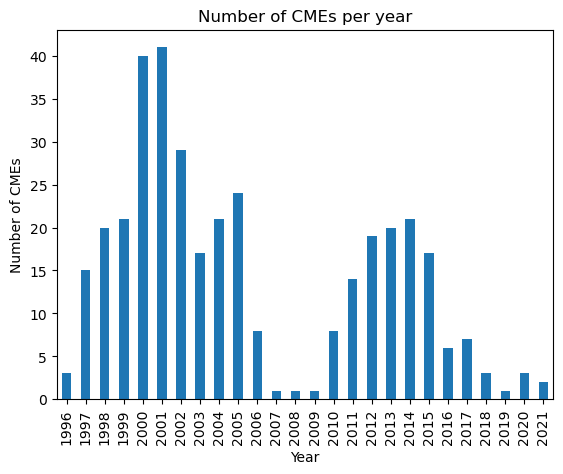

In [5]:
# Number of CMEs per year:
df['year'] = pd.to_datetime(df['disturbance']).dt.year
df['year'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Number of CMEs')
plt.title('Number of CMEs per year')
# delete the year column
df = df.drop(columns=['year'])

Text(0.5, 1.0, 'CME transit time distribution')

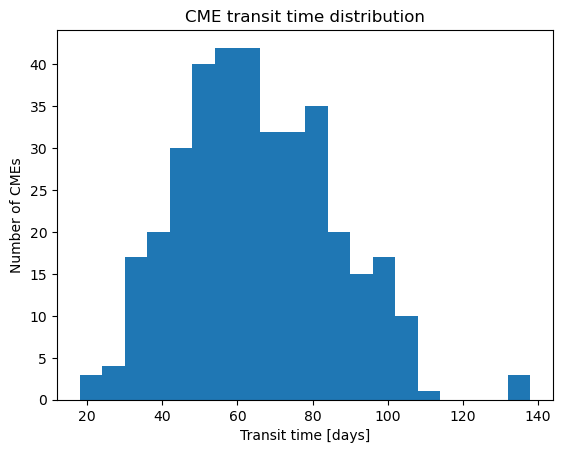

In [6]:
# CME transit time distribution:
df['transit_time'].plot(kind='hist', bins=20)
plt.xlabel('Transit time [days]')
plt.ylabel('Number of CMEs')
plt.title('CME transit time distribution')


In [7]:
# Drop those with more than 120 days of transit time:
df = df[df['transit_time'] <= 120]

In [8]:
# Regression analysis:
from sklearn.linear_model import LinearRegression

ydata = df['transit_time'].values

# ydata = (ydata - ydata.mean())/ydata.std()


# xdata, the rest of the features:
xdata = df.drop(columns=['disturbance', 'transit_time']).values
feature_names = df.drop(columns=['disturbance', 'transit_time']).columns

# # xdata is only the avg_speed:
# xdata = df['final_speed'].values.reshape(-1, 1)
# feature_names = ['final_speed']

# xdata = xdata[:, 5:]
# feature_names = feature_names[5:]

# print(feature_names)

## Regression task:

To test the performance of several models we will use a linear regressor, and an artificial neural network. We will use the mean absolute error (MAE) as the metric to evaluate the performance of the models.

Text(0.5, 1.0, 'Linear regression coefficients')

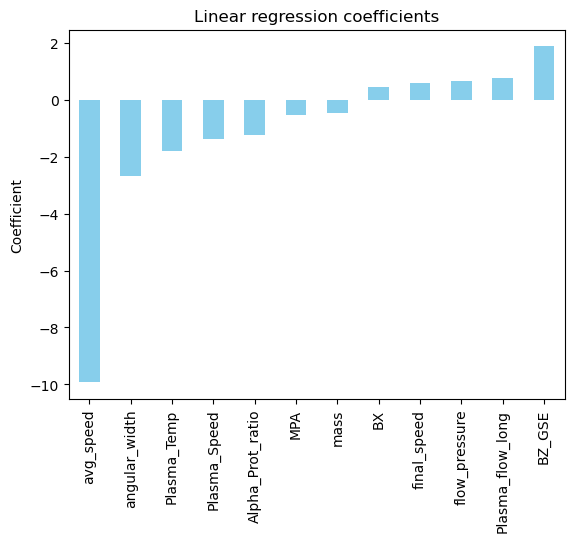

In [9]:
# Standarization of the features:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

xdata_scaled = scaler.fit_transform(xdata)



# Linear regression:
model = LinearRegression()
model.fit(xdata_scaled, ydata)

# Coefficients, sorted vertically:
coefficients = pd.Series(model.coef_, index=feature_names).sort_values()
coefficients.plot(kind='bar', color='skyblue')
plt.ylabel('Coefficient')
plt.title('Linear regression coefficients')
# plt.xticks(rotation=45)


R2 score: 0.3906771570698454
MSE: 231.8551275268057


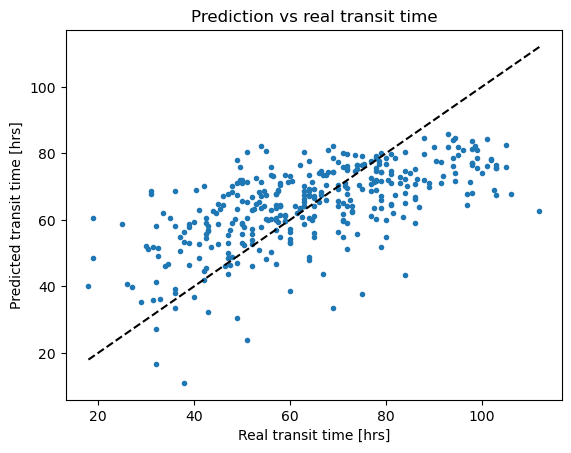

In [10]:
# Prediction vs real transit time:
y_pred = model.predict(xdata_scaled)
plt.scatter(ydata, y_pred, marker='.')   # scatter plot
plt.xlabel('Real transit time [hrs]')
plt.ylabel('Predicted transit time [hrs]')
plt.title('Prediction vs real transit time')
plt.plot([ydata.min(), ydata.max()], [ydata.min(), ydata.max()], color='k', linestyle='--')   # diagonal line

print('R2 score:', model.score(xdata_scaled, ydata))
print('MSE:', np.mean((ydata - y_pred)**2))

R2 score: 0.5217842408396423
MSE: 181.9672068952165


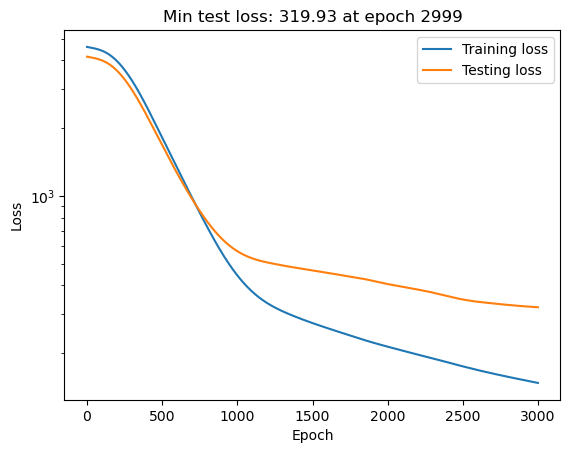

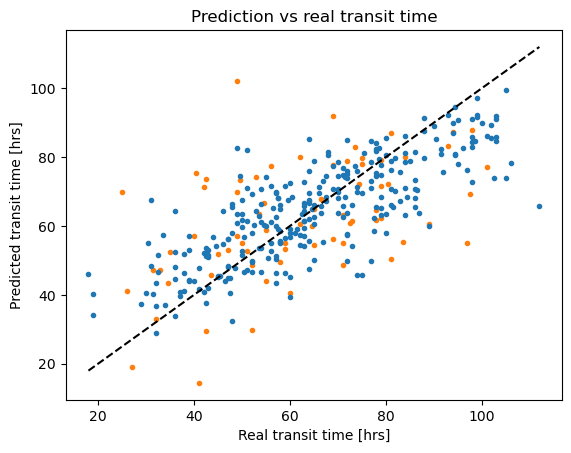

In [11]:
# Artificial neural network with pytorch:
import torch
import torch.nn as nn
import torch.optim as optim

# Neural network:
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 1)
        self.activation = nn.ELU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x
    
    def fit(self, xdata, ydata, epochs=1000, lr=0.01, verbose=True, xtest=None, ytest=None):
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)
        
        xdata_tensor = torch.tensor(xdata, dtype=torch.float32)
        ydata_tensor = torch.tensor(ydata, dtype=torch.float32).reshape(-1, 1)
        
        if xtest is not None and ytest is not None:
            xtest_tensor = torch.tensor(xtest, dtype=torch.float32)
            ytest_tensor = torch.tensor(ytest, dtype=torch.float32).reshape(-1, 1)
        
        loss_train = []
        loss_test = []
        
        for epoch in range(epochs):
            optimizer.zero_grad()
            output = self(xdata_tensor)
            loss = criterion(output, ydata_tensor)
            loss.backward()
            optimizer.step()
            loss_train.append(loss.item())
            
            if epoch % 100 == 0 and verbose:
                print(f'Epoch {epoch}, loss: {loss.item()}', flush=True)
            
            if xtest is not None and ytest is not None:
                loss_test.append(criterion(self(xtest_tensor), ytest_tensor).item())
        
        return loss_train, loss_test
                
                
    def predict(self, xdata):
        xdata_tensor = torch.tensor(xdata, dtype=torch.float32)
        return self(xdata_tensor).detach().numpy().ravel()
    
    def score(self, xdata, ydata):
        y_pred = self.predict(xdata)
        return 1 - np.mean((ydata - y_pred)**2) / np.mean((ydata - ydata.mean())**2)

model = Net(input_size=xdata.shape[1])

# Split the data into training and testing:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(xdata_scaled, ydata, test_size=0.2, random_state=42)


loss_train, loss_test = model.fit(xtrain, ytrain, epochs=3000, lr=0.001, verbose=False, xtest=xtest, ytest=ytest)

plt.plot(loss_train, label='Training loss')
plt.plot(loss_test, label='Testing loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Min test loss: {:.2f} at epoch {}'.format(min(loss_test), np.argmin(loss_test)))
plt.yscale('log')
plt.legend()



# Prediction vs real transit time:
plt.figure()
y_predtest = model.predict(xtest)
plt.scatter(ytest, y_predtest, color='C1', marker='.')   # scatter plot
y_predtrain = model.predict(xtrain)
plt.scatter(ytrain, y_predtrain, color='C0', marker='.')   # scatter plot

plt.xlabel('Real transit time [hrs]')
plt.ylabel('Predicted transit time [hrs]')
plt.title('Prediction vs real transit time')
plt.plot([ydata.min(), ydata.max()], [ydata.min(), ydata.max()], color='k', linestyle='--')   # diagonal line

y_pred = model.predict(xdata_scaled)
print('R2 score:', model.score(xdata_scaled, ydata))
print('MSE:', np.mean((ydata - y_pred)**2))

## Symmbolic regression using pySR:

In [12]:
try:
    import pysr
except:
   %pip install pysr
   import pysr 
    

/Users/carlosjd/anaconda3/envs/pykdb/lib/python3.10/site-packages/juliacall/__init__.py:60: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(


In [19]:
from pysr import PySRRegressor

model = PySRRegressor(niterations=200, binary_operators=["*", "+", "-", "/", "^"], elementwise_loss="loss(predictions, target) = abs(predictions - target)", warm_start=True, constraints={'^': (-1, 3)})
model.fit(xdata_scaled, ydata)





/Users/carlosjd/anaconda3/envs/pykdb/lib/python3.10/site-packages/pysr/sr.py:1297: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/Users/carlosjd/anaconda3/envs/pykdb/lib/python3.10/site-packages/pysr/sr.py:1874: UserWarning: Note: you are running with 10 features or more. Genetic algorithms like used in PySR scale poorly with large numbers of features. You should run PySR for more `niterations` to ensure it can find the correct variables, or, alternatively, do a dimensionality reduction beforehand. For example, `X = PCA(n_components=6).fit_transform(X)`, using scikit-learn's `PCA` class, will reduce the number of features to 6 in an interpretable way, as each resultant feature will be a linear combination of the original features. 
  warnings.warn(



Expressions evaluated per second: 4.670e+05
Head worker occupation: 7.4%
Progress: 980 / 3000 total iterations (32.667%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.603e+01  1.594e+01  y = 63.429
3           1.556e+01  1.496e-02  y = (63.161 - x₂)
5           1.234e+01  1.160e-01  y = (62.993 / (1.2402 ^ x₂))
7           1.224e+01  3.704e-03  y = ((63.429 / (1.2402 ^ x₂)) - x₇)
9           1.204e+01  8.326e-03  y = (((0.64927 + (0.49285 ^ x₂)) + 1.263) / 0.048915)
11          1.189e+01  6.407e-03  y = ((((0.64927 + (0.49285 ^ x₂)) + 1.263) / 0.048915) - x₇)
13          1.179e+01  4.304e-03  y = ((((0.50881 + (0.51162 ^ x₂)) + 1.3572) / 0.048341) - (x₈ ...
                                  + x₇))
15          1.173e+01  2.584e-03  y = (((((0.50881 + (0.51162 ^ x₂)) + 1.3572) / 0.048341) - x₈)...
                                   - (x₈ + x₇))
17          1.163e+0

[ Info: Started!


PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                          63.428997   
	1        0.014965                                   (63.161148 - x2)   
	2  >>>>  0.116163                     (62.992554 / (1.2508762 ^ x2))   
	3        0.011887    (((0.51246417 ^ x2) + 1.7218151) / 0.045839343)   
	4        0.006424  ((((0.51246417 ^ x2) + 1.7218151) / 0.04583934...   
	5        0.006646  ((((0.49238783 ^ x2) + 1.8511366) / 0.04834072...   
	6        0.000928  ((((0.5088066 ^ x2) + 1.9038996) / 0.048340723...   
	7        0.002619  (((((0.5088066 ^ x2) + 1.9038996) / 0.04834072...   
	8        0.002194  (((((0.5088066 ^ x2) + 1.9038996) / 0.04834072...   
	9        0.003007  (((((0.5088066 ^ x2) + 1.9038996) / 0.04834072...   
	
	        loss  complexity  
	0  16.030552           1  
	1  15.557875           3  
	2  12.332541           5  
	3  12.042806           7  
	4  11.889065           9  
	5  11.732072          11  
	6  11.710318          13  
	7  11.649135          15  
	8  11.598134          17  
	9  11.528593          19  
]

R2 score: 0.3790453567423113
MSE: 236.28117617999212


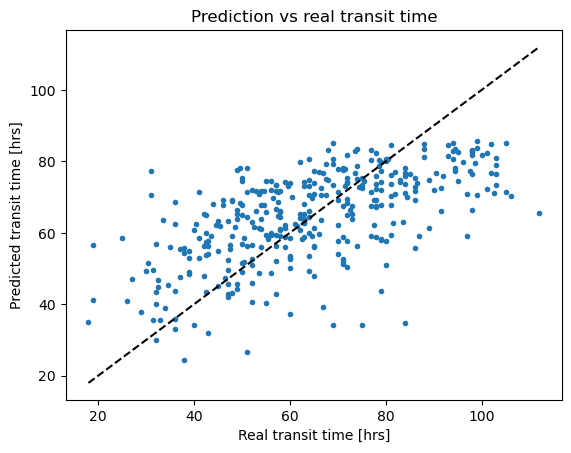

In [20]:
# Prediction vs real transit time:
plt.figure()
y_pred = model.predict(xdata_scaled)
plt.scatter(ydata, y_pred, marker='.')   # scatter plot
plt.xlabel('Real transit time [hrs]')
plt.ylabel('Predicted transit time [hrs]')
plt.title('Prediction vs real transit time')
plt.plot([ydata.min(), ydata.max()], [ydata.min(), ydata.max()], color='k', linestyle='--')   # diagonal line

print('R2 score:', model.score(xdata_scaled, ydata))
print('MSE:', np.mean((ydata - y_pred)**2))
